In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools

In [70]:
plt.style.use('cms')

In [71]:
with pd.HDFStore("hists_3d_gstar.h5") as store:
    print(store.keys())

['/MCAggEvents']


In [72]:
df = pd.read_hdf("hists_3d_gstar.h5", "MCAggEvents")
indexes = df.index.names
df = df.reset_index()
df["binvar1"] = df["binvar1"].astype(int)
df["binvar2"] = df["binvar2"].astype(int)
df = df.set_index(indexes)

df_rw = pd.read_hdf("reweight_id1_id2.h5", "MCWeight")
df_rw.index.names = ["binvar1", "binvar2"]

df = pd.merge(df, df_rw, left_index=True, right_index=True)
df["sum_rw"] = df.eval("sum_w*weight")

# Normalise the reweighting
df_sum = df.groupby(["table", "varname0", "varname1", "varname2", "selection", "parent"]).sum()

df_left = df[["sum_w", "sum_ww", "sum_rw", "weight"]]
df_right = df_sum.eval("sum_w/sum_rw")
df_right.name = "rescale"
df_left = df_left.reorder_levels([
    "table", "varname0", "varname1", "varname2", "selection", "parent",
    "mass_window", "eta_restricted", "large_pt",
    "binvar0", "binvar1", "binvar2",
]).sort_index()
df_right = df_right.reorder_levels([
    "table", "varname0", "varname1", "varname2", "selection", "parent"
]).sort_index()

df = pd.merge(df_left, df_right, left_index=True, right_index=True)
df["sum_rw"] = df.eval("sum_w*weight*rescale")
df["sum_rww"] = df.eval("sum_ww*(weight*rescale)**2")
df = df.reorder_levels(["table", "varname0", "varname1", "varname2", "selection", "parent", "mass_window", "eta_restricted", "large_pt", "binvar0", "binvar1", "binvar2"]).sort_index()

In [73]:
df_pdf = pd.read_hdf("hists_1d_gstar.h5", "MCAggEvents")
df_pdf.head(5)

count  \
table   varname0          varname1      varname2      selection    parent     mass_window large_pt eta_restricted binvar0 binvar1 binvar2          
central GenPartBoson_mass Generator_id1 Generator_id2 DoubleLepton DYJetsToLL False       False    False          0.0     -5.0    5.0        5.0   
                                                                                                                                  21.0       1.0   
                                                                                                                          -4.0    4.0       17.0   
                                                                                                                                  21.0       5.0   
                                                                                                                          -3.0    2.0        2.0   

                                                                                                                                               sum_w  \
table   varname0          varname1      varname2      selection    parent     mass_window large_pt eta_restricted binvar0 binvar1 binvar2              
central GenPartBoson_mass Generator_id1 Generator_id2 DoubleLepton DYJetsToLL False       False    False          0.0     -5.0    5.0      13.023088   
                                                                                                                                  21.0      2.604618   
                                                                                                                          -4.0    4.0      23.441558   
                                                                                                                                  21.0     13.023088   
                                                                                                                          -3.0    2.0       5.209235   

                                                                                                                                               sum_ww  \
table   varname0          varname1      varname2      selection    parent     mass_window large_pt eta_restricted binvar0 binvar1 binvar2               
central GenPartBoson_mass Generator_id1 Generator_id2 DoubleLepton DYJetsToLL False       False    False          0.0     -5.0    5.0       33.920164   
                                                                                                                                  21.0       6.784033   
                                                                                                                          -4.0    4.0      115.328558   
                                                                                                                                  21.0      33.920164   
                                                                                                                          -3.0    2.0       13.568066   

                                                                                                                                           sum_w_alphasUp  \
table   varname0          varname1      varname2      selection    parent     mass_window large_pt eta_restricted binvar0 binvar1 binvar2                   
central GenPartBoson_mass Generator_id1 Generator_id2 DoubleLepton DYJetsToLL False       False    False          0.0     -5.0    5.0           13.142477   
                                                                                                                                  21.0           2.705884   
                                                                                                                          -4.0    4.0           23.892883   
                                                                                                                                  21.0          13.249466   
                       

In [74]:
df.index.get_level_values("varname0").unique()

Index(['GenPartBoson_mass', 'GenPartBoson_pt', 'LeadGenLepCandidate_eta',
       'LeadGenLepCandidate_pt', 'SecondGenLepCandidate_eta',
       'SecondGenLepCandidate_pt'],
      dtype='object', name='varname0')

In [75]:
df.index.get_level_values("selection").unique()

Index(['DoubleLepton'], dtype='object', name='selection')

In [76]:
df.index.get_level_values("parent").unique()

Index(['DYJetsToLL', 'GStarJetsToLL', 'ZJetsToLL'], dtype='object', name='parent')

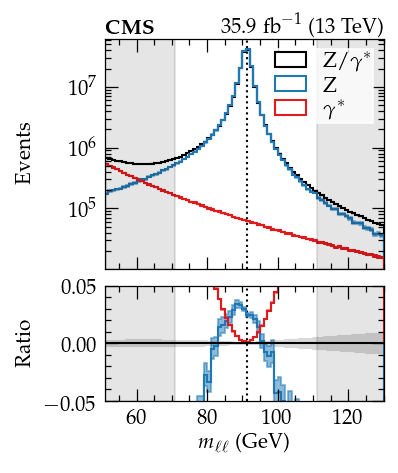

In [77]:
bins = np.arange(50., 130.1, 1.)

df_draw = df.loc[("central", "GenPartBoson_mass", "Generator_id1", "Generator_id2", "DoubleLepton"),:].groupby(
    ["parent", "binvar0"]
).sum()

df_draw = dftools.transform.rebin(df_draw, bins)
bins = np.array(list(bins)+[2*bins[-1]-bins[-2]])

fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2,1), "hspace": 0.1, "wspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_yscale('log')

ax[0].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("DYJetsToLL"), "sum_w"].iloc[1:-1],
    histtype='step', color="black",
    label=r'$\mathrm{Z}/\gamma^*$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("DYJetsToLL"),:].eval("sum_w**2/sum_ww").iloc[1:-1],
    scale=df_draw.loc[("DYJetsToLL"),:].eval("sum_ww/sum_w").iloc[1:-1],
)
ax[0].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#d9d9d9',
)

ax[0].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("ZJetsToLL"), "sum_w"].iloc[1:-1],
    histtype='step', color="#1f78b4",
    label=r'$\mathrm{Z}$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("ZJetsToLL"),:].eval("sum_w**2/sum_ww").iloc[1:-1],
    scale=df_draw.loc[("ZJetsToLL"),:].eval("sum_ww/sum_w").iloc[1:-1],
)
ax[0].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#1f78b4', alpha=0.5,
)

ax[0].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("GStarJetsToLL"), "sum_w"].iloc[1:-1],
    histtype='step', color="#e31a1c",
    label=r'$\gamma^*$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("GStarJetsToLL"),:].eval("sum_w**2/sum_ww").iloc[1:-1],
    scale=df_draw.loc[("GStarJetsToLL"),:].eval("sum_ww/sum_w").iloc[1:-1],
)
ax[0].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#e31a1c',
)

ax[1].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("ZJetsToLL"),"sum_w"].iloc[1:-1]/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1]-1,
    histtype='step', color='#1f78b4',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("ZJetsToLL"),:].eval("sum_w**2/sum_ww").iloc[1:-1],
    scale=df_draw.loc[("ZJetsToLL"),:].eval("sum_ww/sum_w").iloc[1:-1],
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1].values - 1
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1].values - 1
ax[1].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#1f78b4', alpha=0.5,
)

ax[1].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("GStarJetsToLL"),"sum_w"].iloc[1:-1]/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1],
    histtype='step', color='#e31a1c',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("GStarJetsToLL"),:].eval("sum_w**2/sum_ww").iloc[1:-1],
    scale=df_draw.loc[("GStarJetsToLL"),:].eval("sum_ww/sum_w").iloc[1:-1],
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1].values
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1].values
ax[1].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#e31a1c', alpha=0.5,
)

ax[1].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=np.zeros_like(bins[1:-2]),
    histtype='step', color='black',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("DYJetsToLL"),:].eval("sum_w**2/sum_ww").iloc[1:-1],
    scale=df_draw.loc[("DYJetsToLL"),:].eval("sum_ww/sum_w").iloc[1:-1],
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1].values - 1
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_w"].iloc[1:-1].values - 1
ax[1].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#d9d9d9', zorder=-1,
)

ax[1].set_ylim(-0.05, 0.05)

ax[0].axvspan(0., 71., color='black', alpha=0.1)
ax[0].axvspan(111., 500., color='black', alpha=0.1)
ax[0].set_xlim(bins[1], bins[-2])

ax[1].axvspan(0., 71., color='black', alpha=0.1)
ax[1].axvspan(111., 500., color='black', alpha=0.1)

ax[0].legend(loc=1, labelspacing=0.1, borderpad=0.1, framealpha=0.75)

ax[1].set_xlabel(r'$m_{\ell\ell}$ (GeV)')
ax[1].set_ylabel(r'Ratio')
ax[0].set_ylabel(r'Events')

ax[0].axvline(91.1876, lw=1, ls=':', zorder=-1, color='black')
ax[1].axvline(91.1876, lw=1, ls=':', zorder=-1, color='black')

fig.align_labels(ax)
fig.savefig("plots/gstar_invmass.pdf", format="pdf", bbox_inches='tight')

pass

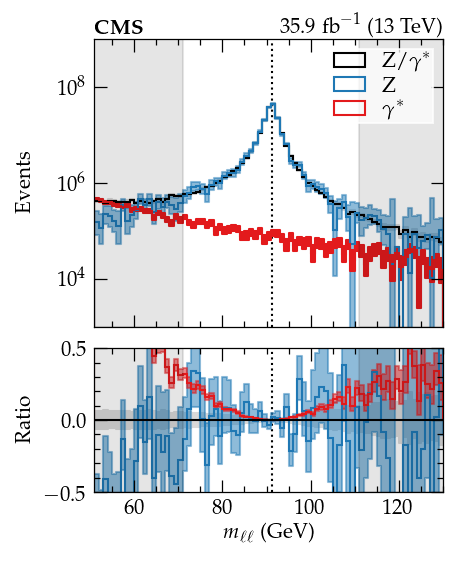

In [78]:
bins = np.arange(50., 130.1, 1.)

df_draw = df.loc[("central", "GenPartBoson_mass", "Generator_id1", "Generator_id2", "DoubleLepton"),:].groupby(
    ["parent", "binvar0"]
).sum()

df_draw = dftools.transform.rebin(df_draw, bins)
bins = np.array(list(bins)+[2*bins[-1]-bins[-2]])

fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2,1), "hspace": 0.1, "wspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_yscale('log')

ax[0].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("DYJetsToLL"), "sum_rw"].iloc[1:-1],
    histtype='step', color="black",
    label=r'$\mathrm{Z}/\gamma^*$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("DYJetsToLL"),:].eval("sum_rw**2/sum_rww").iloc[1:-1],
    scale=df_draw.loc[("DYJetsToLL"),:].eval("sum_rww/sum_rw").iloc[1:-1],
)
ax[0].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#d9d9d9',
)

ax[0].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("ZJetsToLL"), "sum_rw"].iloc[1:-1],
    histtype='step', color="#1f78b4",
    label=r'$\mathrm{Z}$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("ZJetsToLL"),:].eval("sum_rw**2/sum_rww").iloc[1:-1],
    scale=df_draw.loc[("ZJetsToLL"),:].eval("sum_rww/sum_rw").iloc[1:-1],
)
ax[0].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#1f78b4', alpha=0.5,
)

ax[0].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("GStarJetsToLL"), "sum_rw"].iloc[1:-1],
    histtype='step', color="#e31a1c",
    label=r'$\gamma^*$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("GStarJetsToLL"),:].eval("sum_rw**2/sum_rww").iloc[1:-1],
    scale=df_draw.loc[("GStarJetsToLL"),:].eval("sum_rww/sum_rw").iloc[1:-1],
)
ax[0].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#e31a1c',
)

ax[1].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("ZJetsToLL"),"sum_rw"].iloc[1:-1]/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1]-1,
    histtype='step', color='#1f78b4',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("ZJetsToLL"),:].eval("sum_rw**2/sum_rww").iloc[1:-1],
    scale=df_draw.loc[("ZJetsToLL"),:].eval("sum_rww/sum_rw").iloc[1:-1],
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1].values - 1
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1].values - 1
ax[1].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#1f78b4', alpha=0.5,
)

ax[1].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=df_draw.loc[("GStarJetsToLL"),"sum_rw"].iloc[1:-1]/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1],
    histtype='step', color='#e31a1c',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("GStarJetsToLL"),:].eval("sum_rw**2/sum_rww").iloc[1:-1],
    scale=df_draw.loc[("GStarJetsToLL"),:].eval("sum_rww/sum_rw").iloc[1:-1],
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1].values
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1].values
ax[1].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#e31a1c', alpha=0.5,
)

ax[1].hist(
    bins[1:-2],
    bins=bins[1:-1],
    weights=np.zeros_like(bins[1:-2]),
    histtype='step', color='black',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("DYJetsToLL"),:].eval("sum_rw**2/sum_rww").iloc[1:-1],
    scale=df_draw.loc[("DYJetsToLL"),:].eval("sum_rww/sum_rw").iloc[1:-1],
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1].values - 1
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_rw"].iloc[1:-1].values - 1
ax[1].fill_between(
    bins[1:-1], list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#d9d9d9', zorder=-1,
)

ax[1].set_ylim(-0.5, 0.5)

ax[0].axvspan(0., 71., color='black', alpha=0.1)
ax[0].axvspan(111., 500., color='black', alpha=0.1)
ax[0].set_xlim(bins[1], bins[-2])

ax[1].axvspan(0., 71., color='black', alpha=0.1)
ax[1].axvspan(111., 500., color='black', alpha=0.1)

ax[0].legend(loc=1, labelspacing=0.1, borderpad=0.1, framealpha=0.75)

ax[1].set_xlabel(r'$m_{\ell\ell}$ (GeV)')
ax[1].set_ylabel(r'Ratio')
ax[0].set_ylabel(r'Events')

ax[0].axvline(91.1876, lw=1, ls=':', zorder=-1, color='black')
ax[1].axvline(91.1876, lw=1, ls=':', zorder=-1, color='black')

fig.align_labels(ax)
ax[0].set_ylim(1e3, 1e9)

pass

In [79]:
df.loc[("central", "GenPartBoson_pt"),:].index.get_level_values("binvar0").unique()

Float64Index([   0.0,    5.0,   10.0,   15.0,   20.0,   25.0,   30.0,   35.0,
                40.0,   45.0,
              ...
              1505.0, 1595.0, 1610.0, 1695.0, 1735.0, 1795.0, 2525.0, 1170.0,
              1235.0, 1120.0],
             dtype='float64', name='binvar0', length=275)

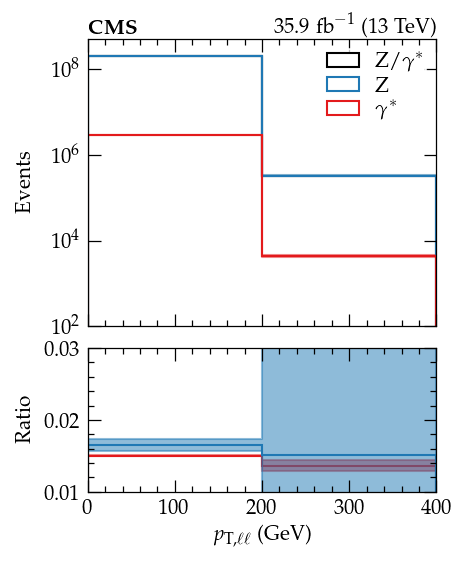

In [85]:
bins = np.array([0, 200])

df_draw = df.loc[("central", "GenPartBoson_pt", "Generator_id1", "Generator_id2", "DoubleLepton", pd.IndexSlice[:], True),:].groupby(
    ["parent", "binvar0"]
).sum()

df_draw = dftools.transform.rebin(df_draw, bins)
bins = np.array(list(bins)+[2*bins[-1]-bins[-2]])

fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2,1), "hspace": 0.1, "wspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")
ax[0].set_yscale('log')

ax[0].hist(
    bins[:-1],
    bins=bins,
    weights=df_draw.loc[("DYJetsToLL"), "sum_w"],
    histtype='step', color="black",
    label=r'$\mathrm{Z}/\gamma^*$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("DYJetsToLL"),:].eval("sum_w**2/sum_ww"),
    scale=df_draw.loc[("DYJetsToLL"),:].eval("sum_ww/sum_w"),
)
ax[0].fill_between(
    bins, list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#d9d9d9',
)

ax[0].hist(
    bins[:-1],
    bins=bins,
    weights=df_draw.loc[("ZJetsToLL"), "sum_w"],
    histtype='step', color="#1f78b4",
    label=r'$\mathrm{Z}$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("ZJetsToLL"),:].eval("sum_w**2/sum_ww"),
    scale=df_draw.loc[("ZJetsToLL"),:].eval("sum_ww/sum_w"),
)
ax[0].fill_between(
    bins, list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#1f78b4', alpha=0.5,
)

ax[0].hist(
    bins[:-1],
    bins=bins,
    weights=df_draw.loc[("GStarJetsToLL"), "sum_w"],
    histtype='step', color="#e31a1c",
    label=r'$\gamma^*$',
)
lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("GStarJetsToLL"),:].eval("sum_w**2/sum_ww"),
    scale=df_draw.loc[("GStarJetsToLL"),:].eval("sum_ww/sum_w"),
)
ax[0].fill_between(
    bins, list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#e31a1c', alpha=0.5,
)

ax[1].hist(
    bins[:-1],
    bins=bins,
    weights=df_draw.loc[("ZJetsToLL"),"sum_w"]/df_draw.loc[("DYJetsToLL"),"sum_w"]-1,
    histtype='step', color='#1f78b4',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("ZJetsToLL"),:].eval("sum_w**2/sum_ww"),
    scale=df_draw.loc[("ZJetsToLL"),:].eval("sum_ww/sum_w"),
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_w"].values - 1
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_w"].values - 1
ax[1].fill_between(
    bins, list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#1f78b4', alpha=0.5,
)

ax[1].hist(
    bins[:-1],
    bins=bins,
    weights=df_draw.loc[("GStarJetsToLL"),"sum_w"]/df_draw.loc[("DYJetsToLL"),"sum_w"],
    histtype='step', color='#e31a1c', zorder=-1,
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("GStarJetsToLL"),:].eval("sum_w**2/sum_ww"),
    scale=df_draw.loc[("GStarJetsToLL"),:].eval("sum_ww/sum_w"),
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_w"].values
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_w"].values
ax[1].fill_between(
    bins, list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#e31a1c', alpha=0.5, zorder=-1,
)

ax[1].hist(
    bins[:-1],
    bins=bins,
    weights=np.zeros_like(bins[:-1]),
    histtype='step', color='black',
)

lower, upper = dftools.stats.poisson_interval(
    df_draw.loc[("DYJetsToLL"),:].eval("sum_w**2/sum_ww"),
    scale=df_draw.loc[("DYJetsToLL"),:].eval("sum_ww/sum_w"),
)
lower = lower/df_draw.loc[("DYJetsToLL"),"sum_w"].values - 1
upper = upper/df_draw.loc[("DYJetsToLL"),"sum_w"].values - 1
ax[1].fill_between(
    bins, list(lower)+[lower[-1]], list(upper)+[upper[-1]],
    step='post', color='#d9d9d9', zorder=-1,
)

ax[1].set_ylim(0.01, 0.03)
ax[0].set_xlim(bins[0], bins[-1])

ax[0].legend(loc=1, labelspacing=0.1, borderpad=0.1, framealpha=0.75)

ax[1].set_xlabel(r'$p_{\mathrm{T},\ell\ell}$ (GeV)')
ax[1].set_ylabel(r'Ratio')
ax[0].set_ylabel(r'Events')

fig.align_labels(ax)
ax[0].set_ylim(1e2, 5e8)

pass

## Nominal

In [86]:
data = []

In [87]:
df_calc = df.loc[("central", "GenPartBoson_mass", "Generator_id1", "Generator_id2", "DoubleLepton", pd.IndexSlice[:], True),:].groupby(
    ["parent"]
).sum()
df_calc = df_calc.stack()

g = df_calc.loc[("GStarJetsToLL", "sum_w")]
z = df_calc.loc[("ZJetsToLL", "sum_w")]
dy = df_calc.loc[("DYJetsToLL", "sum_w")]

glower, gupper = dftools.stats.poisson_interval(
    df_calc.loc[("GStarJetsToLL", "sum_w")]**2/df_calc.loc[("GStarJetsToLL", "sum_ww")],
    scale=df_calc.loc[("GStarJetsToLL", "sum_ww")]/df_calc.loc[("GStarJetsToLL", "sum_w")],
)

zlower, zupper = dftools.stats.poisson_interval(
    df_calc.loc[("ZJetsToLL", "sum_w")]**2/df_calc.loc[("ZJetsToLL", "sum_ww")],
    scale=df_calc.loc[("ZJetsToLL", "sum_ww")]/df_calc.loc[("ZJetsToLL", "sum_w")],
)

dylower, dyupper = dftools.stats.poisson_interval(
    df_calc.loc[("DYJetsToLL", "sum_w")]**2/df_calc.loc[("DYJetsToLL", "sum_ww")],
    scale=df_calc.loc[("DYJetsToLL", "sum_ww")]/df_calc.loc[("DYJetsToLL", "sum_w")],
)

kz = z/dy
kg = g/dy

kzlower = kz*(1-np.sqrt((zlower/z-1)**2 + (dyupper/dy-1)**2))
kzupper = kz*(1+np.sqrt((zupper/z-1)**2 + (dylower/dy-1)**2))
              
kglower = kg*(1-np.sqrt((glower/g-1)**2 + (dyupper/dy-1)**2))
kgupper = kg*(1+np.sqrt((gupper/g-1)**2 + (dylower/dy-1)**2))

print(f'kz =  {kz:.4f} + {100.*(kzupper-kz)/kz:.4f} - {100.*(kz-kzlower)/kz:.4f}')
print(f'kg =  {kg:.4f} + {100.*(kgupper-kg)/kg:.4f} - {100.*(kg-kglower)/kg:.4f}')
print(kz)
print(kg)

data.extend([{
    "parameter": "kz",
    "value": kz,
    "statUp": kzupper,
    "statDown": kzlower,
}, {
    "parameter": "kg",
    "value": kg,
    "statUp": kgupper,
    "statDown": kglower,
}])

kz =  1.0165 + 0.0825 - 0.0824
kg =  0.0150 + 0.1487 - 0.1485
1.016459098800746
0.015040229236138198


In [91]:
df_results = pd.DataFrame(data)
df_results

,parameter,value,statUp,statDown
0,kz,1.016459,1.017297,1.015621
1,kg,0.015040,0.015063,0.015018


## Generator id1-id2 reweighting

In [92]:
df_calc = df.loc[("central", "GenPartBoson_mass", "Generator_id1", "Generator_id2", "DoubleLepton", pd.IndexSlice[:], True),:].groupby(
    ["parent"]
).sum()
df_calc = df_calc.stack()

g = df_calc.loc[("GStarJetsToLL", "sum_rw")]
z = df_calc.loc[("ZJetsToLL", "sum_rw")]
dy = df_calc.loc[("DYJetsToLL", "sum_rw")]

glower, gupper = dftools.stats.poisson_interval(
    df_calc.loc[("GStarJetsToLL", "sum_rw")]**2/df_calc.loc[("GStarJetsToLL", "sum_rww")],
    scale=df_calc.loc[("GStarJetsToLL", "sum_rww")]/df_calc.loc[("GStarJetsToLL", "sum_rw")],
)

zlower, zupper = dftools.stats.poisson_interval(
    df_calc.loc[("ZJetsToLL", "sum_rw")]**2/df_calc.loc[("ZJetsToLL", "sum_rww")],
    scale=df_calc.loc[("ZJetsToLL", "sum_rww")]/df_calc.loc[("ZJetsToLL", "sum_rw")],
)

dylower, dyupper = dftools.stats.poisson_interval(
    df_calc.loc[("DYJetsToLL", "sum_rw")]**2/df_calc.loc[("DYJetsToLL", "sum_rww")],
    scale=df_calc.loc[("DYJetsToLL", "sum_rww")]/df_calc.loc[("DYJetsToLL", "sum_rw")],
)

kz = z/dy
kg = g/dy

kzlower = kz*(1-np.sqrt((zlower/z-1)**2 + (dyupper/dy-1)**2))
kzupper = kz*(1+np.sqrt((zupper/z-1)**2 + (dylower/dy-1)**2))
              
kglower = kg*(1-np.sqrt((glower/g-1)**2 + (dyupper/dy-1)**2))
kgupper = kg*(1+np.sqrt((gupper/g-1)**2 + (dylower/dy-1)**2))

print(f'kz =  {kz:.4f} + {kzupper-kz:.4f} - {kz-kzlower:.4f}')
print(f'kg =  {kg:.4f} + {kgupper-kg:.4f} - {kg-kglower:.4f}')
print(kz)
print(kg)
df_results["genIdReweightUp"] = df_results["value"] + np.abs(df_results["value"] - np.array([kz, kg]))
df_results["genIdReweightDown"] = df_results["value"] - np.abs(df_results["value"] - np.array([kz, kg]))

kz =  1.0018 + 0.0150 - 0.0148
kg =  0.0171 + 0.0005 - 0.0005
1.001817699992845
0.017067842799732266


In [94]:
df_results

,parameter,value,statUp,statDown,genIdReweightUp,genIdReweightDown
0,kz,1.016459,1.017297,1.015621,1.031100,1.001818
1,kg,0.015040,0.015063,0.015018,0.017068,0.013013


## PDF variations

In [99]:
tdf_pdf = df_pdf.groupby(["parent", "mass_window"]).sum()
tdf_pdf = tdf_pdf.loc[(pd.IndexSlice[:], True),:].groupby(["parent"]).sum()
tdf_pdf = tdf_pdf/tdf_pdf.loc[("DYJetsToLL"),:]

#print("kz(alphas): {:.4f} + {:.4f} - {:.4f}".format(
#    tdf_pdf.loc["ZJetsToLL","sum_w"],
#    tdf_pdf.loc["ZJetsToLL","sum_w_alphasUp"]-tdf_pdf.loc["ZJetsToLL","sum_w"],
#    tdf_pdf.loc["ZJetsToLL","sum_w"]-tdf_pdf.loc["ZJetsToLL","sum_w_alphasDown"],
#))
#
#print("kg(alphas): {:.4f} + {:.4f} - {:.4f}".format(
#    tdf_pdf.loc["GStarJetsToLL","sum_w"],
#    tdf_pdf.loc["GStarJetsToLL","sum_w_alphasUp"]-tdf_pdf.loc["GStarJetsToLL","sum_w"],
#    tdf_pdf.loc["GStarJetsToLL","sum_w"]-tdf_pdf.loc["GStarJetsToLL","sum_w_alphasDown"],
#))

tdf_scale_down = tdf_pdf.loc[:, "sum_w"]-tdf_pdf.loc[:, (c for c in tdf_pdf.columns if "sum_w_lheScale" in c)].min(axis=1)
tdf_scale_up = tdf_pdf.loc[:, (c for c in tdf_pdf.columns if "sum_w_lheScale" in c)].max(axis=1)-tdf_pdf.loc[:, "sum_w"]

print("kz(scale): {:.6f} + {:.6f} [\%] - {:.6f} [\%]".format(
    tdf_pdf.loc["ZJetsToLL","sum_w"],
    100.*tdf_scale_up["ZJetsToLL"]/tdf_pdf.loc["ZJetsToLL","sum_w"],
    100.*tdf_scale_down["ZJetsToLL"]/tdf_pdf.loc["ZJetsToLL","sum_w"],
))

print("kg(scale): {:.6f} + {:.6f} [\%] - {:.6f} [\%]".format(
    tdf_pdf.loc["GStarJetsToLL","sum_w"],
    100.*tdf_scale_up["GStarJetsToLL"]/tdf_pdf.loc["GStarJetsToLL","sum_w"],
    100.*tdf_scale_down["GStarJetsToLL"]/tdf_pdf.loc["GStarJetsToLL","sum_w"],
))

tdf_pdf_std = tdf_pdf.loc[:, (c for c in tdf_pdf.columns if "sum_w_lhePdf" in c)].std(axis=1)
print("kz(pdf): {:.6f} + {:.6f} [\%] - {:.6f} [\%]".format(
    tdf_pdf.loc["ZJetsToLL","sum_w"],
    100.*tdf_pdf_std["ZJetsToLL"]/tdf_pdf.loc["ZJetsToLL","sum_w"],
    100.*tdf_pdf_std["ZJetsToLL"]/tdf_pdf.loc["ZJetsToLL","sum_w"],
))

print("kg(pdf): {:.6f} + {:.6f} [\%] - {:.6f} [\%]".format(
    tdf_pdf.loc["GStarJetsToLL","sum_w"],
    100.*tdf_pdf_std["GStarJetsToLL"]/tdf_pdf.loc["GStarJetsToLL","sum_w"],
    100.*tdf_pdf_std["GStarJetsToLL"]/tdf_pdf.loc["GStarJetsToLL","sum_w"],
))
df_results["lhePdfWeightUp"] = np.array([
     tdf_pdf.loc["ZJetsToLL", "sum_w"] + tdf_pdf_std["ZJetsToLL"],
     tdf_pdf.loc["GStarJetsToLL", "sum_w"] + tdf_pdf_std["GStarJetsToLL"],
])
df_results["lhePdfWeightDown"] = np.array([
     tdf_pdf.loc["ZJetsToLL", "sum_w"] - tdf_pdf_std["ZJetsToLL"],
     tdf_pdf.loc["GStarJetsToLL", "sum_w"] - tdf_pdf_std["GStarJetsToLL"],
])
df_results["lheScaleWeightUp"] = np.array([
     tdf_pdf.loc["ZJetsToLL", "sum_w"] + tdf_scale_up["ZJetsToLL"],
     tdf_pdf.loc["GStarJetsToLL", "sum_w"] + tdf_scale_up["GStarJetsToLL"],
])
df_results["lheScaleWeightDown"] = np.array([
     tdf_pdf.loc["ZJetsToLL", "sum_w"] - tdf_scale_down["ZJetsToLL"],
     tdf_pdf.loc["GStarJetsToLL", "sum_w"] - tdf_scale_down["GStarJetsToLL"],
])

kz(scale): 1.016459 + 0.000000 [\%] - 0.000000 [\%]
kg(scale): 0.015040 + 0.000000 [\%] - 0.000000 [\%]
kz(pdf): 1.016459 + 2.297680 [\%] - 2.297680 [\%]
kg(pdf): 0.015040 + 2.433525 [\%] - 2.433525 [\%]


In [100]:
#df_results.to_hdf(
#    "gstar_prediction.h5", "GStarPredictions",
#    format="table", append=True,
#    complevel=9, complib='zlib',
#)